In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
import pandas as pd
import seaborn as sns
from helpers import sns_styleset
%matplotlib inline

In [2]:
sns_styleset()

In [3]:
skeleton_data=loadmat('./data/Skeletons_HC_BC_cones.mat')
M=np.loadtxt('./data/coordinate_rotation')
BC_ids=np.loadtxt('./data/BC_IDs_new') #column 0 are BC IDs, column 4 Type IDs

skeleton_ids=skeleton_data['kn_allSkeletons_e2006_IDs'].flatten()
skeletons=skeleton_data['kn_allSkeletons_e2006'][0]
HC_ids=skeleton_ids[(skeleton_ids>1901)&(skeleton_ids<2000)]

BC_types = ['1','2','3A','3B','4','5T','5O','5I','X','6','7','8','9']

#Type correspondence:
#58 59 60 61 62 63 64 65 66 67 68 69 70 71
#1   2 3A 3B 4  5T 5O 5I X  6  7  8  9  RBC

#### Identify BCs that have at least ~50% overlap with the HC dendritic field

In [4]:
#calculate mean points of BC
BC_means=[]
for cell in np.unique(skeleton_ids[skeleton_ids<1900]):
    mean=[]
    for i in np.where(skeleton_ids==cell)[0]:
        nodes=skeletons[i].item()[list(skeletons[i].dtype.names).index('nodes')][:,:3]
        nodes=np.dot(M,nodes.T).T
        nodes=nodes/[16.5,16.5,25]
        if nodes.shape[0]>1:
            mean.append(np.mean(nodes[:,1:],axis=0))
    mean=np.array(mean).reshape(-1,2)
    if mean.shape[0]>0:
        BC_means.append([cell,np.mean(mean[:,0]),np.mean(mean[:,1])])
BC_means=np.array(BC_means)

In [5]:
#get polygons from convex hull of HC skeletons
polygons=[]
for HC in HC_ids:
    i=np.where(skeleton_ids==HC)[0].item()
    nodes=skeletons[i].item()[list(skeletons[i].dtype.names).index('nodes')][:,:3]
    nodes=np.dot(M,nodes.T).T
    nodes=nodes/[16.5,16.5,25]
    hull=ConvexHull(nodes[:,1:])
    polygons.append(Polygon(nodes[hull.vertices,1:])) 

In [6]:
#create a list of BC with mean outside of HC convex hulls
BC_excluded=[]
for i in range(BC_ids.shape[0]):
    inside=False
    for j in range(len(polygons)):
        if polygons[j].contains(Point(BC_means[i,1:])):
            inside=True
    if not inside:
        BC_excluded.append(BC_ids[i,0])

### Create Dataframe with contacts from all HC, columns HC, contact ID

In [7]:
bulb_data=pd.read_csv('./data/HC_bulb_contacts.csv',delimiter=';')

In [8]:
print('Number of bulbs:', len(bulb_data))
print('With identified contacts:', len(bulb_data[~np.isnan(bulb_data['cell1'])]))
print('With BC contacts:',len(bulb_data[(bulb_data['cell1']<1900)|(bulb_data['cell2']<1900)|(bulb_data['cell3']<1900)]))
print('With HC contacts:',len(bulb_data[(bulb_data['cell1']>1900)|(bulb_data['cell2']>1900)|(bulb_data['cell3']>1900)]))

Number of bulbs: 545
With identified contacts: 355
With BC contacts: 288
With HC contacts: 136


In [9]:
all_contacts=bulb_data[['HC','cell1','cell2','cell3']].melt(id_vars=['HC'],value_name='contacted').drop(['variable'],1)
all_contacts=all_contacts[all_contacts['contacted']<2000]
all_contacts=all_contacts.dropna(axis=0).reset_index().drop('index',1)


In [10]:
all_contacts['type']=80
for i in range(all_contacts.shape[0]):
    try:
        all_contacts.loc[i,'type']=BC_ids[BC_ids[:,0]==all_contacts.loc[i,'contacted'],4].item()
    except ValueError:
        continue

In [11]:
stat_HC_contacts = pd.DataFrame({1902: np.zeros(13),1903:np.zeros(13),1904:np.zeros(13),
                                 1905:np.zeros(13),1906:np.zeros(13),})
stat_HC_contacts.index = np.arange(58,71)
for key in stat_HC_contacts:
    idx,count = np.unique(all_contacts[all_contacts['HC']==key]['type'],return_counts=True)
    for i in range(len(count)):
        stat_HC_contacts[key][idx[i]] = count[i]

In [12]:
contact_count=all_contacts.groupby(by=['contacted','type'],as_index=False).count()

In [13]:
stat_BC_contacts=pd.DataFrame(BC_ids[np.in1d(BC_ids[:,0],BC_excluded,invert=True)][:,[0,4]],columns=['BC','type'])
stat_BC_contacts['count']=0
for i in range(contact_count.shape[0]):
    stat_BC_contacts.loc[stat_BC_contacts['BC']==contact_count.loc[i,'contacted'],'count']=contact_count.loc[i,'HC']

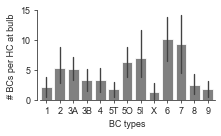

In [14]:
plt.figure(figsize=(8/2.54,5/2.54),tight_layout=True)
ax=sns.barplot(data=stat_HC_contacts.T,color='grey')
sns.despine()
ax.spines['left'].set_position(('outward',3))
ax.set(xticklabels=BC_types,\
       xlabel='BC types',ylabel='# BCs per HC at bulb',yticks=[0,5,10,15])
# plt.savefig('./figures/Fig2I_BC_bulb_contacts_HC.svg',dpi=300)
plt.show()

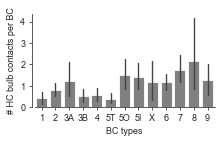

In [15]:
plt.figure(figsize=(8/2.54,5/2.54),tight_layout=True)
ax=sns.barplot(data=stat_BC_contacts[stat_BC_contacts['type']<71],x='type',y='count',ci=95,color='grey')
ax.spines['left'].set_position(('outward',3))
sns.despine()
ax.set(xticklabels=BC_types,xlabel='BC types',ylabel='# HC bulb contacts per BC')
# plt.savefig('./figures/Fig2J_BC_bulb_contacts_BC.svg',dpi=300)
plt.show()